In [8]:
import pandas as pd
import numpy as np
#from gensim.models import KeyedVectors # gensim not compatible with numpy>=2.0
import re

In [ ]:
train_data = pd.read_pickle('../00_data/clean/en_es_train_data.pkl')
train_data.head()

In [ ]:
working_df = train_data[['token', 'part_of_speech', 'prompt']]
working_df.head()

In [16]:
# Ensure english tokens normalized
en_vocab = set(working_df['token'].str.lower())

# Spanish words from prompts (keep diacritics; strip punctuation)
SPANISH_KEEP = r"[^A-Za-z0-9_áéíóúüñÁÉÍÓÚÜÑ]"  # drop everything else
def es_words(s: str):
    if not isinstance(s, str):
        return []
    out = []
    for w in s.split():
        w = re.sub(SPANISH_KEEP, "", w).lower()
        if w:
            out.append(w)
    return out

es_vocab = set()
for s in working_df['prompt']:
    es_vocab.update(es_words(s))
    '''if isinstance(s, str):
        es_vocab.update(es_words(s))'''

print(f"EN vocab: {len(en_vocab)} | ES vocab: {len(es_vocab)}")

EN vocab: 1967 | ES vocab: 2367


In [12]:
# Code to load fastText vectors
EN_VEC = "../00_data/raw/wiki.en.align.vec"
ES_VEC = "../00_data/raw/wiki.es.align.vec"

def load_subset_vecs(vec_path: str, vocab: set[str], dtype=np.float32):
    """
    Load only rows whose 'word' is in vocab from a .vec text embedding file.
    Returns: dict[word] -> np.ndarray[d]
    """
    vecs = {}
    with open(vec_path, "r", encoding="utf-8", errors="ignore") as f:
        # Detect an optional header line "n d"
        first = f.readline()
        parts = first.strip().split()
        header = len(parts) == 2 and all(p.isdigit() for p in parts)

        def parse_line(line):
            # split only on spaces; first token is the word, rest are floats
            sp = line.rstrip("\n").split(" ")
            if not sp:
                return None, None
            word, *vals = sp
            return word, vals

        if not header:
            # first line is data
            w, vals = parse_line(first)
            if w in vocab:
                vecs[w] = np.asarray(vals, dtype=dtype)

        for line in f:
            w, vals = parse_line(line)
            if w in vocab:
                vecs[w] = np.asarray(vals, dtype=dtype)

    # sanity check: all vectors same dimension
    dims = {v.shape[0] for v in vecs.values()}
    if len(dims) != 1:
        raise ValueError(f"Inconsistent dims in {vec_path}: {dims}")
    return vecs


en_vecs = load_subset_vecs(EN_VEC, en_vocab)
es_vecs = load_subset_vecs(ES_VEC, es_vocab)
print(f"Loaded EN: {len(en_vecs)} | ES: {len(es_vecs)} | dim={next(iter(en_vecs.values())).shape[0]}")


Loaded EN: 1954 | ES: 2354 | dim=300


In [17]:
# Compute similarities
def cos_sim(a: np.ndarray, b: np.ndarray, eps=1e-12) -> float:
    a = a / (np.linalg.norm(a) + eps)
    b = b / (np.linalg.norm(b) + eps)
    return float(a @ b)

def row_scores(row, topk=3):
    token = row['token'].lower()
    if token not in en_vecs:
        return np.nan, None, []
    tvec = en_vecs[token]
    words = [w for w in es_words(row['prompt']) if w in es_vecs]
    if not words:
        return np.nan, None, []

    scored = [(w, cos_sim(tvec, es_vecs[w])) for w in words]
    scored.sort(key=lambda x: x[1], reverse=True)
    best_word, best_sim = scored[0]
    return best_sim, best_word, scored[:topk]

out = working_df.copy()
out['max_sim'], out['best_es'], out['top3_es'] = zip(*out.apply(row_scores, axis=1))
out[['token','prompt','max_sim','best_es','top3_es']].head()

,token,prompt,max_sim,best_es,top3_es
0,i,Yo soy un niño.,0.242132,yo,"[(yo, 0.24213218688964844), (soy, 0.1722080409..."
1,am,Yo soy un niño.,0.280849,soy,"[(soy, 0.280849426984787), (yo, 0.182461321353..."
2,a,Yo soy un niño.,0.441548,un,"[(un, 0.44154781103134155), (niño, 0.095649838..."
3,boy,Yo soy un niño.,0.402527,niño,"[(niño, 0.40252676606178284), (soy, 0.16678625..."
4,i,Yo soy de México.,0.242132,yo,"[(yo, 0.24213218688964844), (soy, 0.1722080409..."


In [ ]:
'''def cos_sim(a: np.ndarray, b: np.ndarray, eps=1e-12) -> float:
    a = a / (np.linalg.norm(a) + eps)
    b = b / (np.linalg.norm(b) + eps)
    return float(a @ b)

def row_scores(row, topk=3):
    token = row.get('token')
    if not isinstance(token, str):
        return np.nan, None, []
    token = token.lower()

    if token not in en_vecs:
        return np.nan, None, []

    tvec = en_vecs[token]

    prompt = row.get('prompt')
    words = [w for w in es_words(prompt) if w in es_vecs]
    if not words:
        return np.nan, None, []

    scored = [(w, cos_sim(tvec, es_vecs[w])) for w in words]
    scored.sort(key=lambda x: x[1], reverse=True)
    best_word, best_sim = scored[0]
    return best_sim, best_word, scored[:topk]

out = working_df.copy()

# Cleaner assignment without zip(*...)
out[['max_sim','best_es','top3_es']] = out.apply(row_scores, axis=1, result_type='expand')

out[['token','prompt','max_sim','best_es','top3_es']].head()'''

,token,prompt,max_sim,best_es,top3_es
0,i,Yo soy un niño.,0.242132,yo,"[(yo, 0.24213218688964844), (soy, 0.1722080409..."
1,am,Yo soy un niño.,0.280849,soy,"[(soy, 0.280849426984787), (yo, 0.182461321353..."
2,a,Yo soy un niño.,0.441548,un,"[(un, 0.44154781103134155), (niño, 0.095649838..."
3,boy,Yo soy un niño.,0.402527,niño,"[(niño, 0.40252676606178284), (soy, 0.16678625..."
4,i,Yo soy de México.,0.242132,yo,"[(yo, 0.24213218688964844), (soy, 0.1722080409..."


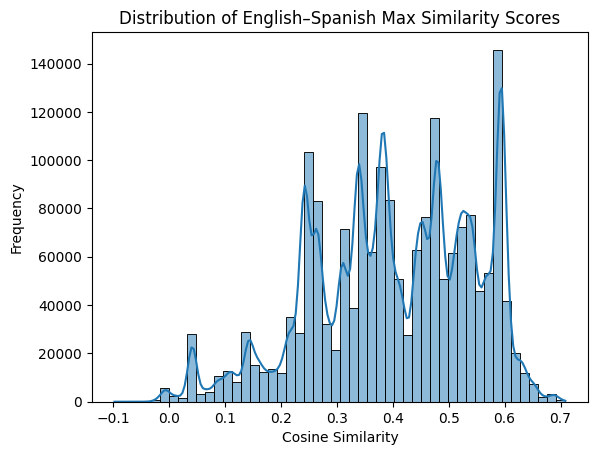

In [21]:
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(out['max_sim'].dropna(), bins=50, kde=True)
plt.title("Distribution of English–Spanish Max Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Average similarity per POS
pos_sim = out.groupby('part_of_speech')['max_sim'].mean().sort_values(ascending=False)
pos_sim.plot(kind='bar', figsize=(10,4), title='Mean Similarity by Part of Speech')
plt.ylabel("Mean max_sim")

In [ ]:
sns.boxplot(x='part_of_speech', y='max_sim', data=out)
plt.xticks(rotation=45)
plt.title("Distribution of Similarity by POS")

In [ ]:
out.nlargest(10, 'max_sim')[['token', 'best_es', 'max_sim']]

In [ ]:
out.nsmallest(10, 'max_sim')[['token', 'prompt', 'max_sim']]

In [ ]:
from sklearn.decomposition import PCA

sample_words = ['boy','girl','dog','cat','house','niño','niña','perro','gato','casa']
vecs, labels, langs = [], [], []

for w in sample_words:
    if w in en_vecs:
        vecs.append(en_vecs[w]); labels.append(w); langs.append('EN')
    elif w in es_vecs:
        vecs.append(es_vecs[w]); labels.append(w); langs.append('ES')

pca = PCA(n_components=2)
coords = pca.fit_transform(np.stack(vecs))

plt.figure(figsize=(6,6))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=langs)
for (x, y, l) in zip(coords[:,0], coords[:,1], labels):
    plt.text(x+0.02, y+0.02, l, fontsize=9)
plt.title("PCA Projection of Selected EN–ES Words")
plt.show()

In [ ]:
freq = working_df['token'].str.lower().value_counts()
out['freq'] = out['token'].str.lower().map(freq)
sns.scatterplot(x=np.log1p(out['freq']), y=out['max_sim'])
plt.xlabel("log(Token Frequency)")
plt.ylabel("Max Similarity")
plt.title("Frequency vs. Similarity")